In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Data Preparation

### Create dataset

In [2]:
# Create datasets

dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Alzheimers-Detection/data/Dementia')
no_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Alzheimers-Detection/data/No_Dementia')

patient_ids = []
class_labels = []
image_paths = []
prefix = '/data/Dementia/'

for path in dementia_image_paths:
    patient_ids.append(path.split('_')[1])
    image_paths.append(prefix + path)
    class_labels.append(1)

prefix = '/data/No_Dementia/' 
for path in no_dementia_image_paths:
    patient_ids.append(path.split('_')[1])
    image_paths.append(prefix + path)
    class_labels.append(0)

df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df


,patient_id,image_path,class_label
0,0308,/data/Dementia/OAS1_0308_MR1_mpr-1_125.jpg,1
1,0351,/data/Dementia/OAS1_0351_MR1_mpr-3_112.jpg,1
2,0003,/data/Dementia/OAS1_0003_MR1_mpr-4_145.jpg,1
3,0003,/data/Dementia/OAS1_0003_MR1_mpr-4_151.jpg,1
4,0308,/data/Dementia/OAS1_0308_MR1_mpr-1_131.jpg,1
...,...,...,...
2924,0005,/data/No_Dementia/OAS1_0005_MR1_mpr-3_146.jpg,0
2925,0005,/data/No_Dementia/OAS1_0005_MR1_mpr-3_152.jpg,0
2926,0004,/data/No_Dementia/OAS1_0004_MR1_mpr-3_154.jpg,0
2927,0001,/data/No_Dementia/OAS1_0001_MR1_mpr-2_152.jpg,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [3]:
train_df = df[df['patient_id'].isin(['0351', '0021', '0003', '0308', '0002', '0004', '0006', '0009'])]
train_df = train_df.reset_index()
print(len(train_df))

test_df = df[df['patient_id'].isin(['0028', '0031', '0001', '0005'])]
test_df = test_df.reset_index()
print(len(test_df))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

1952
976
Train Ratio:  0.6664390576988733
Test Ratio:  0.3332195288494367


# Data Pipeline

### Defining Transforms

In [4]:
# Importing the custom dataset class
from alzheimers_dataset import alzheimers_dataset
import torchvision.transforms as tf

In [5]:
# Simple transforms for baseline model
transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.ToTensor(),
    ])

In [19]:
# Create datasets based on custom dataset class
root_dir = '/Users/aatyanth/COGS181/Alzheimers-Detection'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=test_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2, drop_last=True)

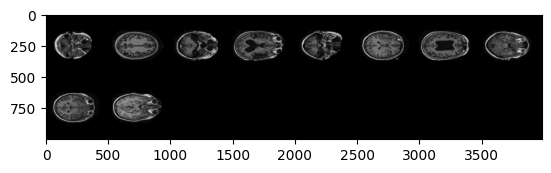

No Alzheimers No Alzheimers Alzheimers Alzheimers Alzheimers No Alzheimers Alzheimers No Alzheimers No Alzheimers No Alzheimers


In [20]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images))
classes = ("No Alzheimers", "Alzheimers")
print(" ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement AlzheimersNet Class

In [8]:
class AlzheimersNet(nn.Module):
    
    def __init__(self):
        super(AlzheimersNet, self).__init__()
        
        # Initializing Convolution Blocks
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.AvgPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        
        # Initializing Linear Layers
        self.fc1 = nn.Linear(in_features=(64*18*18), out_features=512)
        self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
    
    def forward(self, x):
        
        # implement the convolution blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the layers
        flattened = torch.flatten(x, start_dim=1)
        # implement the fully connected network
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Store the output of the FCN
        output = F.relu(self.fc4(x))
        
        return output

# Training Implementation

In [9]:
# Choose the device
device = torch.device("cuda0" if torch.cuda.is_available() else "cpu")

# Create an instance of the Network
cnn = AlzheimersNet()

# Loss and optimizer to use
loss_func = nn.CrossEntropyLoss()
sgd = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Moving network parameters to the chosen device
cnn.to(device)

AlzheimersNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [10]:
from tqdm import tqdm
# Training Procedure

avg_losses = []
epochs = 5
print_freq = 10
predictions_list = []

for epoch in tqdm(range(epochs), desc="Training Completion"):
    running_loss = 0.0
    for batch, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zeroing the gradients
        sgd.zero_grad()
        
        # Generate predictions
        outputs = cnn(inputs)
        
        # Compute loss based on predictions and ground truth
        loss = loss_func(outputs, labels)
        
        # Take backwards step
        loss.backward()
        
        # Update the network parameters
        sgd.step()
        
        running_loss += loss.item()
        
        if batch % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, batch, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Training Complete.')

Training Completion:   0%|          | 0/5 [00:00<?, ?it/s]

[epoch: 0, i:     9] avg mini-batch loss: 0.690
[epoch: 0, i:    19] avg mini-batch loss: 0.681
[epoch: 0, i:    29] avg mini-batch loss: 0.671
[epoch: 0, i:    39] avg mini-batch loss: 0.637
[epoch: 0, i:    49] avg mini-batch loss: 0.611
[epoch: 0, i:    59] avg mini-batch loss: 0.572
[epoch: 0, i:    69] avg mini-batch loss: 0.506
[epoch: 0, i:    79] avg mini-batch loss: 0.450
[epoch: 0, i:    89] avg mini-batch loss: 0.403
[epoch: 0, i:    99] avg mini-batch loss: 0.363
[epoch: 0, i:   109] avg mini-batch loss: 0.247
[epoch: 0, i:   119] avg mini-batch loss: 0.247
[epoch: 0, i:   129] avg mini-batch loss: 0.212
[epoch: 0, i:   139] avg mini-batch loss: 0.163
[epoch: 0, i:   149] avg mini-batch loss: 0.145
[epoch: 0, i:   159] avg mini-batch loss: 0.092
[epoch: 0, i:   169] avg mini-batch loss: 0.103
[epoch: 0, i:   179] avg mini-batch loss: 0.072
[epoch: 0, i:   189] avg mini-batch loss: 0.090


Training Completion:  20%|██        | 1/5 [01:27<05:50, 87.57s/it]

[epoch: 1, i:     9] avg mini-batch loss: 0.035
[epoch: 1, i:    19] avg mini-batch loss: 0.041
[epoch: 1, i:    29] avg mini-batch loss: 0.073
[epoch: 1, i:    39] avg mini-batch loss: 0.018
[epoch: 1, i:    49] avg mini-batch loss: 0.046
[epoch: 1, i:    59] avg mini-batch loss: 0.027
[epoch: 1, i:    69] avg mini-batch loss: 0.013
[epoch: 1, i:    79] avg mini-batch loss: 0.023
[epoch: 1, i:    89] avg mini-batch loss: 0.011
[epoch: 1, i:    99] avg mini-batch loss: 0.008
[epoch: 1, i:   109] avg mini-batch loss: 0.010
[epoch: 1, i:   119] avg mini-batch loss: 0.011
[epoch: 1, i:   129] avg mini-batch loss: 0.008
[epoch: 1, i:   139] avg mini-batch loss: 0.016
[epoch: 1, i:   149] avg mini-batch loss: 0.010
[epoch: 1, i:   159] avg mini-batch loss: 0.009
[epoch: 1, i:   169] avg mini-batch loss: 0.004
[epoch: 1, i:   179] avg mini-batch loss: 0.004
[epoch: 1, i:   189] avg mini-batch loss: 0.005


Training Completion:  40%|████      | 2/5 [03:00<04:33, 91.01s/it]

[epoch: 2, i:     9] avg mini-batch loss: 0.004
[epoch: 2, i:    19] avg mini-batch loss: 0.005
[epoch: 2, i:    29] avg mini-batch loss: 0.003
[epoch: 2, i:    39] avg mini-batch loss: 0.005
[epoch: 2, i:    49] avg mini-batch loss: 0.008
[epoch: 2, i:    59] avg mini-batch loss: 0.010
[epoch: 2, i:    69] avg mini-batch loss: 0.003
[epoch: 2, i:    79] avg mini-batch loss: 0.007
[epoch: 2, i:    89] avg mini-batch loss: 0.004
[epoch: 2, i:    99] avg mini-batch loss: 0.004
[epoch: 2, i:   109] avg mini-batch loss: 0.004
[epoch: 2, i:   119] avg mini-batch loss: 0.004
[epoch: 2, i:   129] avg mini-batch loss: 0.002
[epoch: 2, i:   139] avg mini-batch loss: 0.003
[epoch: 2, i:   149] avg mini-batch loss: 0.002
[epoch: 2, i:   159] avg mini-batch loss: 0.002
[epoch: 2, i:   169] avg mini-batch loss: 0.006
[epoch: 2, i:   179] avg mini-batch loss: 0.004
[epoch: 2, i:   189] avg mini-batch loss: 0.002


Training Completion:  60%|██████    | 3/5 [04:26<02:56, 88.45s/it]

[epoch: 3, i:     9] avg mini-batch loss: 0.003
[epoch: 3, i:    19] avg mini-batch loss: 0.002
[epoch: 3, i:    29] avg mini-batch loss: 0.002
[epoch: 3, i:    39] avg mini-batch loss: 0.001
[epoch: 3, i:    49] avg mini-batch loss: 0.002
[epoch: 3, i:    59] avg mini-batch loss: 0.002
[epoch: 3, i:    69] avg mini-batch loss: 0.001
[epoch: 3, i:    79] avg mini-batch loss: 0.003
[epoch: 3, i:    89] avg mini-batch loss: 0.002
[epoch: 3, i:    99] avg mini-batch loss: 0.002
[epoch: 3, i:   109] avg mini-batch loss: 0.002
[epoch: 3, i:   119] avg mini-batch loss: 0.002
[epoch: 3, i:   129] avg mini-batch loss: 0.001
[epoch: 3, i:   139] avg mini-batch loss: 0.001
[epoch: 3, i:   149] avg mini-batch loss: 0.001
[epoch: 3, i:   159] avg mini-batch loss: 0.001
[epoch: 3, i:   169] avg mini-batch loss: 0.003
[epoch: 3, i:   179] avg mini-batch loss: 0.001
[epoch: 3, i:   189] avg mini-batch loss: 0.001


Training Completion:  80%|████████  | 4/5 [05:55<01:28, 88.61s/it]

[epoch: 4, i:     9] avg mini-batch loss: 0.002
[epoch: 4, i:    19] avg mini-batch loss: 0.002
[epoch: 4, i:    29] avg mini-batch loss: 0.002
[epoch: 4, i:    39] avg mini-batch loss: 0.002
[epoch: 4, i:    49] avg mini-batch loss: 0.001
[epoch: 4, i:    59] avg mini-batch loss: 0.001
[epoch: 4, i:    69] avg mini-batch loss: 0.001
[epoch: 4, i:    79] avg mini-batch loss: 0.001
[epoch: 4, i:    89] avg mini-batch loss: 0.001
[epoch: 4, i:    99] avg mini-batch loss: 0.001
[epoch: 4, i:   109] avg mini-batch loss: 0.001
[epoch: 4, i:   119] avg mini-batch loss: 0.001
[epoch: 4, i:   129] avg mini-batch loss: 0.001
[epoch: 4, i:   139] avg mini-batch loss: 0.001
[epoch: 4, i:   149] avg mini-batch loss: 0.001
[epoch: 4, i:   159] avg mini-batch loss: 0.002
[epoch: 4, i:   169] avg mini-batch loss: 0.002
[epoch: 4, i:   179] avg mini-batch loss: 0.001
[epoch: 4, i:   189] avg mini-batch loss: 0.001


Training Completion: 100%|██████████| 5/5 [07:23<00:00, 88.70s/it]

Training Complete.


### Training Loss Curve

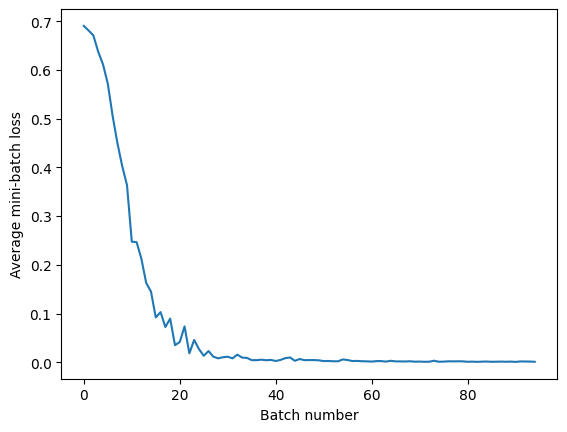

In [11]:
plt.plot(avg_losses)
plt.xlabel("Batch number")
plt.ylabel("Average mini-batch loss")
plt.show()

# Evaluation

In [21]:
# Test Accuracy

total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = cnn(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        correct_predictions += (predicted == labels).sum().item()
        
        

print("Accuracy of the Network on Test Data: ", (100 * (correct_predictions/total_samples)))

Accuracy of the Network on Test Data:  69.58762886597938


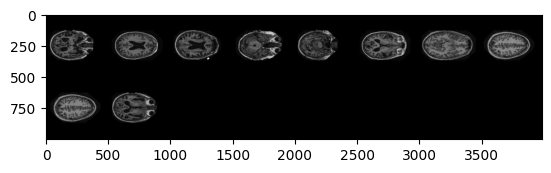

Predictions:  Alzheimers Alzheimers No Alzheimers Alzheimers Alzheimers Alzheimers No Alzheimers No Alzheimers No Alzheimers Alzheimers
Ground Truth:  Alzheimers No Alzheimers Alzheimers Alzheimers Alzheimers No Alzheimers No Alzheimers No Alzheimers No Alzheimers Alzheimers


In [22]:
# Visualize a few predictions
iteration = iter(test_loader)
images, labels = next(iteration)
images, labels = next(iteration)
show_image(torchvision.utils.make_grid(images))
outputs = cnn(images.to(device))
_, predictions = torch.max(outputs.data, 1)
classes = ("No Alzheimers", "Alzheimers")
print("Predictions: ", " ".join('%5s' % classes[predictions[i]] for i in range(10)))
print("Ground Truth: ", " ".join('%5s' % classes[labels[j]] for j in range(10)))

In [24]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of No Alzheimers : 49 %
Accuracy of Alzheimers : 89 %
